# Open pose 出力 2D関節座標からの腕立て伏せ UP_DOWN 二値分類モデル学習　-＞ 動画解析例

## データの読み込み

In [40]:
import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [3]:
# COCO データセットの関節名
# Human3.6M の関節名と統一 RAnkle -> RFoot
# Human3.6M に含まれない？　or モデルの学習に用いていない REye.LEye,REar,LEar, Bkg等 は除かれる
#  StackedHourglass モデルに比べて足りない点 : Head, Hip, Spine, Thorax（胸郭)
# そもそも Stacked Hourglass は何のデータから訓練したのか? COCO を用いているのであれば同じであるべき

# 役割としては  下記の対応が考えられる Hip は RHip, LHipの中間値を用いる考えも，
# COCO : Neck < - > SH : Throax 
# COCO : Nose < - > SH : Head  

#     POSE_COCO_BODY_PARTS {
#         {0,  "Nose"},
#         {1,  "Neck"},
#         {2,  "RShoulder"},
#         {3,  "RElbow"},
#         {4,  "RWrist"},
#         {5,  "LShoulder"},
#         {6,  "LElbow"},
#         {7,  "LWrist"},
#         {8,  "RHip"},
#         {9,  "RKnee"},
#         {10, "RAnkle"},
#         {11, "LHip"},
#         {12, "LKnee"},
#         {13, "LAnkle"},
#         {14, "REye"},
#         {15, "LEye"},
#         {16, "REar"},
#         {17, "LEar"},
#         {18, "Bkg"},
#     }

COCO_NAMES = ['']*19
COCO_NAMES[0] = 'Head'
COCO_NAMES[1] = 'Thorax'
COCO_NAMES[2] = 'RShoulder'
COCO_NAMES[3] = 'RElbow'
COCO_NAMES[4] = 'RWrist'
COCO_NAMES[5] = 'LShoulder'
COCO_NAMES[6] = 'LElbow'
COCO_NAMES[7] = 'LWrist'
COCO_NAMES[8] = 'RHip'
COCO_NAMES[9] = 'RKnee'
COCO_NAMES[10] = 'RFoot'
COCO_NAMES[11] = 'LHip'
COCO_NAMES[12] = 'LKnee'
COCO_NAMES[13] = 'LFoot'
COCO_NAMES[14] = 'Reye' 
COCO_NAMES[15] = 'LEye'
COCO_NAMES[16] = 'REar'
COCO_NAMES[17] = 'LEar'
COCO_NAMES[18] = 'Bkg'

In [24]:
# データを読み込み, 欠損データを削除, ラベルを生成,　
df_up = pd.read_csv('./data/openpose-work/pict_push-ups/2-1.COCO-pose/0_up.csv', header=None)
df_down = pd.read_csv('./data/openpose-work/pict_push-ups/2-1.COCO-pose/1_down.csv', header=None)

df_up = df_up.dropna()
df_up[0] = df_up[0].values.astype('float')
df_up['label'] = np.zeros(df_up.shape[0])

df_down = df_down.dropna()
df_down[0] = df_down[0].values.astype('float')
df_down['label'] = np.ones(df_down.shape[0])

df = pd.concat([df_up, df_down], axis=0, ignore_index=True)

train, test = train_test_split(df, test_size=0.1, random_state=12)

train_x = train[train.columns[:54]]
train_y = train['label']

sc = StandardScaler()
train_x_sc = sc.fit_transform(train_x)

## XGBoostモデルの学習, 交差検証法で確認

In [5]:
# 入力されたモデルを 交差検証法で確認する関数
def cv(model, x, y, cv=10):
    return np.average(cross_val_score(model, x, y, cv=10, scoring='accuracy'))

In [27]:
# xgbモデルの精度を 交差検証法で確認
xgb_model = xgb.XGBClassifier()
xgb_cv = cv(xgb_model, train_x, train_y)
xgb_cv

0.80421052631578949

In [28]:
# xgbモデルの精度を 正規化したデータを用いた交差検証法で確認
# 正規化してもしなくてもこの場合は影響なし
xgb_model = xgb.XGBClassifier()
xgb_cv = cv(xgb_model, train_x_sc, train_y)
xgb_cv

0.80421052631578949

In [80]:
col_names = ['']*train_x.shape[1]
for  i in range(len(COCO_NAMES)-1):
    base = (i-1)*3
    col_names[base] = '{0}_x'.format(COCO_NAMES[i])
    col_names[base+1] = '{0}_y'.format(COCO_NAMES[i])
    col_names[base+2] = '{0}_p'.format(COCO_NAMES[i])

([<matplotlib.axis.XTick at 0x10fba4be0>,
 <a list of 54 Text xticklabel objects>)

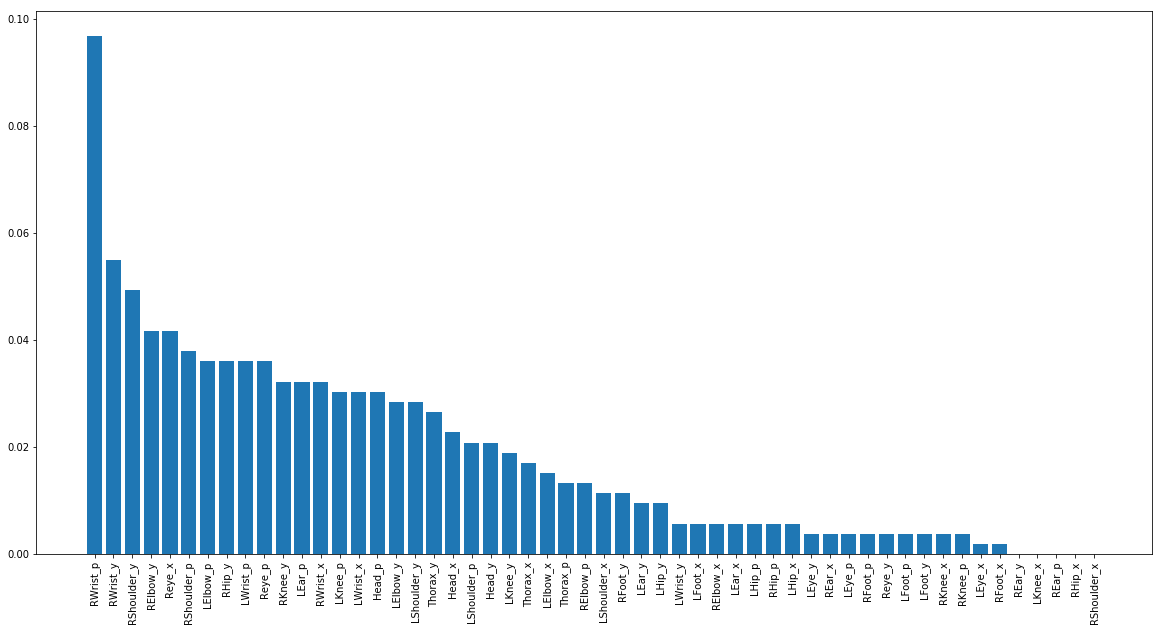

In [82]:
# xgb モデルにおける 重要度を抽出
xgb_model.fit(train_x, train_y)
imp = xgb_model.feature_importances_

sortIdx = np.argsort(imp)[::-1]

plt.figure(figsize=(20,10))
plt.bar(range(len(sortIdx)), imp[sortIdx])
plt.xticks(range(len(sortIdx)), np.array(col_names)[sortIdx], rotation=90)


In [85]:
# 上半身の値のみから モデルを学習させてみる

# target = ['Head', 'Thorax', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
target = ['Head', 'Thorax', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
dim_to_use_x    = np.where(np.array([name in target for name  in COCO_NAMES]))[0] * 3
dim_to_use_y    = dim_to_use_x+1
dim_to_use_p    = dim_to_use_x+2

dim_to_use = np.zeros(len(dim_to_use_x)*3,dtype=np.int32)
dim_to_use[0::3] = dim_to_use_x
dim_to_use[1::3] = dim_to_use_y
dim_to_use[2::3] = dim_to_use_p

train_x_upperbody = train_x[dim_to_use]

sc = StandardScaler()
train_x_upperbody_sc = sc.fit_transform(train_x_upperbody)

# xgbモデルの精度を 交差検証法で確認
xgb_model = xgb.XGBClassifier()
xgb_cv = cv(xgb_model, train_x_upperbody, train_y)
xgb_cv

0.85078947368421054

In [17]:
cross_val_score(xgb_model, train_x,train_y, cv=10, scoring='accuracy')

array([ 0.85      ,  0.7       ,  0.8       ,  0.85      ,  0.89473684,
        0.84210526,  0.73684211,  0.68421053,  0.94736842,  0.73684211])

## 横からの姿勢データのみでモデル検証

In [98]:
# データを読み込み, 欠損データを削除, ラベルを生成,　
df_up = pd.read_csv('./data/openpose-work/pict_push-ups-from-side/2-1.COCO-pose/0_up.csv', header=None)
df_down = pd.read_csv('./data/openpose-work/pict_push-ups-from-side/2-1.COCO-pose/1_down.csv', header=None)

df_up = df_up.dropna()
df_up[0] = df_up[0].values.astype('float')
df_up['label'] = np.zeros(df_up.shape[0])

df_down = df_down.dropna()
df_down[0] = df_down[0].values.astype('float')
df_down['label'] = np.ones(df_down.shape[0])

df = pd.concat([df_up, df_down], axis=0, ignore_index=True)

train, test = train_test_split(df, test_size=0.1, random_state=12)

train_x = train[train.columns[:54]]
train_y = train['label']

# xgbモデルの精度を 交差検証法で確認
xgb_model = xgb.XGBClassifier()
xgb_cv = cv(xgb_model, train_x, train_y)
xgb_cv

0.81309523809523798

In [99]:
# 上半身の値のみから モデルを学習させてみる

target = ['Head', 'Thorax', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
dim_to_use_x    = np.where(np.array([name in target for name  in COCO_NAMES]))[0] * 3
dim_to_use_y    = dim_to_use_x+1
dim_to_use_p    = dim_to_use_x+2

dim_to_use = np.zeros(len(dim_to_use_x)*3,dtype=np.int32)
dim_to_use[0::3] = dim_to_use_x
dim_to_use[1::3] = dim_to_use_y
dim_to_use[2::3] = dim_to_use_p

train_x_upperbody = train_x[dim_to_use]

# xgbモデルの精度を 交差検証法で確認
xgb_model = xgb.XGBClassifier()
xgb_cv = cv(xgb_model, train_x_upperbody, train_y)
xgb_cv

0.87420634920634921

In [103]:
xgb_model.fit(train_x_upperbody, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## 横からの姿勢データかつ，上半身の値のみで学習したモデルで， 横から撮影した動画の各フレームに対して up, down を予測

- 沈み込んでいる時にOpenPose 姿勢推定失敗
- 顔の向きを変えた瞬間に 常に Up 判定

([<matplotlib.axis.XTick at 0x11810dcc0>,
 <a list of 50 Text xticklabel objects>)

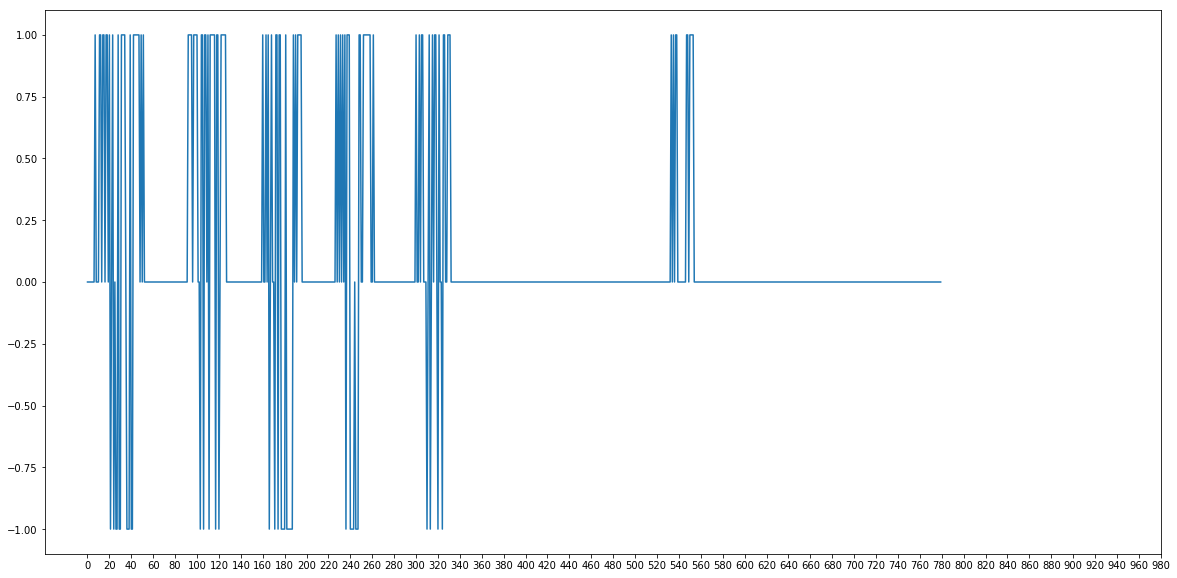

In [160]:
# データの読み込み， OpenPoseが姿勢推定に失敗したデータに対しては −１のラベルを与える

df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_4936.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))

- 沈み込んでいる時に Down(=1) の判定をしてほしいが， Up(=0) の判定をしてしまう（学習データを増せば対応可能？）

([<matplotlib.axis.XTick at 0x1186c14e0>,
 <a list of 50 Text xticklabel objects>)

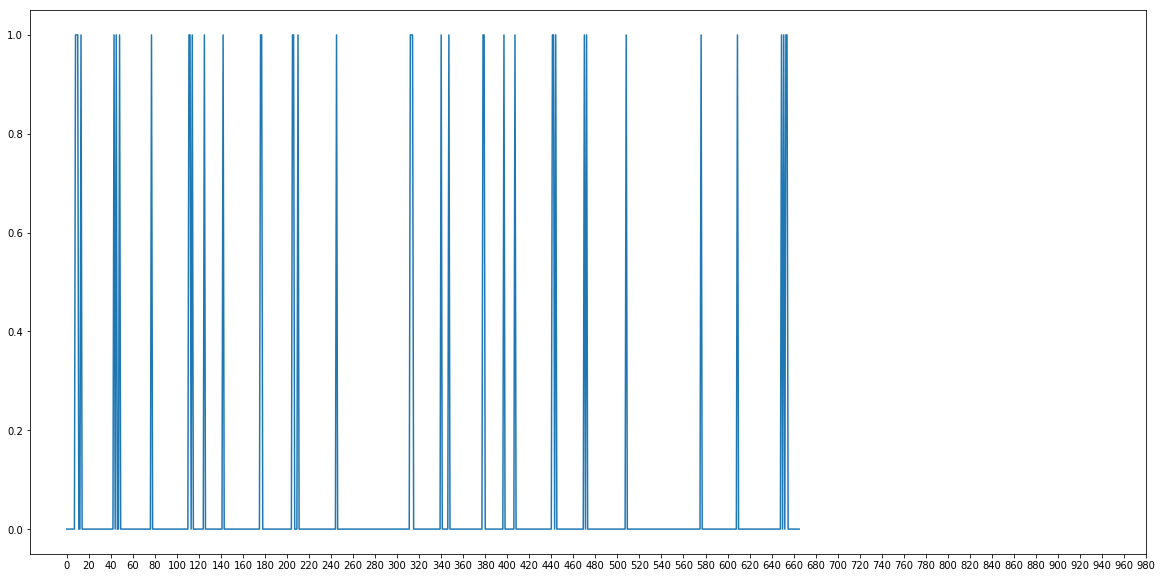

In [161]:
df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174622.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))